<a href="https://colab.research.google.com/github/salemAlaidaroos/Used-Cars-Price-Prediction/blob/main/Used_Cars_EDA_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Used Cars Prices**



---

#  **Dataset**
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

Craigslist used car listings dataset.

#  Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import kagglehub

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')



#  Read the Data

In [ ]:
# Download latest version from Kaggle
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'craigslist-carstrucks-data' dataset.
Path to dataset files: /kaggle/input/craigslist-carstrucks-data


In [ ]:
# Load the dataset
cars_path = os.path.join(path, 'vehicles.csv')
df_cars = pd.read_csv(cars_path)

print(f"Dataset shape: {df_cars.shape}")
df_cars.head()

Dataset shape: (426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


#  Exploratory Data Analysis (EDA)



In [ ]:
# Check data types and structure
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

>  Dataset has 426,880 entries with 26 columns. Mix of data types (int, float, object).

**Check for Missing Values**

In [ ]:
# Analyze missing values
missing_percentage = (df_cars.isnull().sum() / len(df_cars)) * 100
missing_data = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing_Percentage': missing_percentage.values
})
missing_data = missing_data[missing_data['Missing_Percentage'] > 0].sort_values('Missing_Percentage', ascending=False)

print("Missing Data Analysis:")
missing_data.head(10)

Missing Data Analysis:


,Column,Missing_Percentage
21,county,100.000000
16,size,71.767476
9,cylinders,41.622470
8,condition,40.785232
14,VIN,37.725356
15,drive,30.586347
18,paint_color,30.501078
17,type,21.752717
6,manufacturer,4.133714
12,title_status,1.930753


>  Many columns have missing values - `manufacturer` (4% missing), `cylinders` (41% missing), `condition` (40% missing), `size` have 72% missing and `county` is basically an empty column. We need to handle missing data carefully.

**Summary Statistics**

In [ ]:
# Descriptive statistics for numerical columns
df_cars.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


> Price ranges from 0 to 3.7B. Mean price ~$75k suggests outliers. Year ranges 1900-2022. Odometer shows max 10M miles .

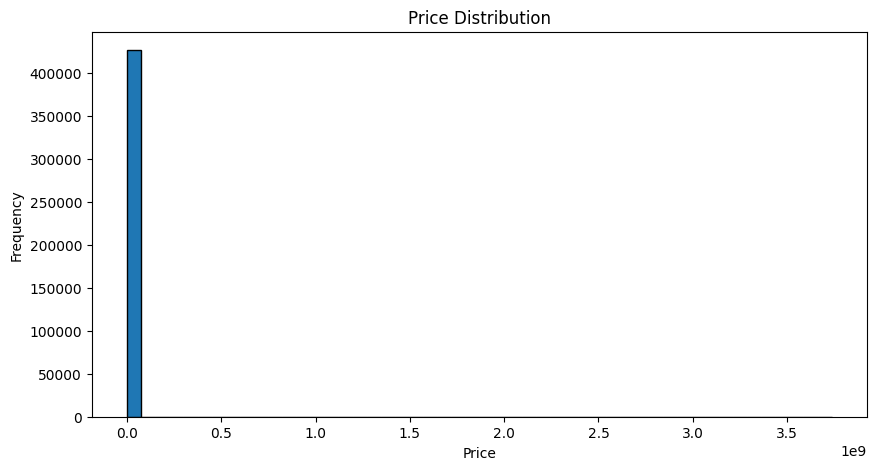

In [ ]:
# Price distribution (target variable)
plt.figure(figsize=(10, 5))
plt.hist(df_cars['price'].dropna(), bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

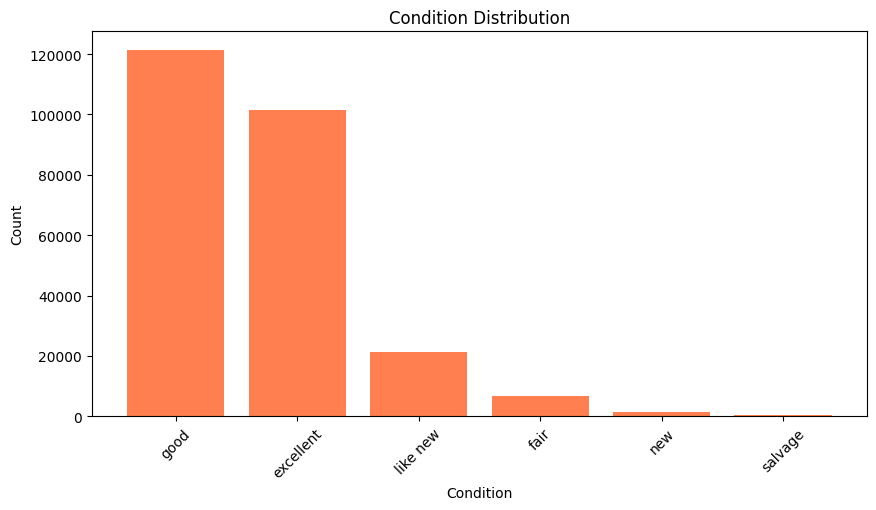

In [ ]:
# Condition distribution
condition_counts = df_cars['condition'].value_counts()
plt.figure(figsize=(10, 5))
plt.bar(condition_counts.index, condition_counts.values, color='coral')
plt.title('Condition Distribution')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

> "Excellent" condition has the most listings (70k), followed by "good" (50k).

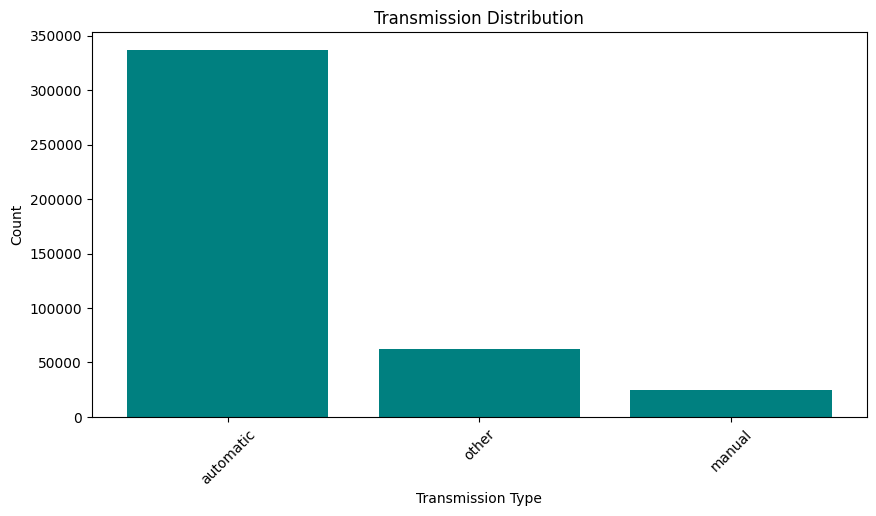

In [ ]:
# Transmission distribution
transmission_counts = df_cars['transmission'].value_counts()
plt.figure(figsize=(10, 5))
plt.bar(transmission_counts.index, transmission_counts.values, color='teal')
plt.title('Transmission Distribution')
plt.xlabel('Transmission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

>"Automatic" transmission is overwhelmingly dominant with ~330k listings. "Manual" has ~75k, "other" is rare.

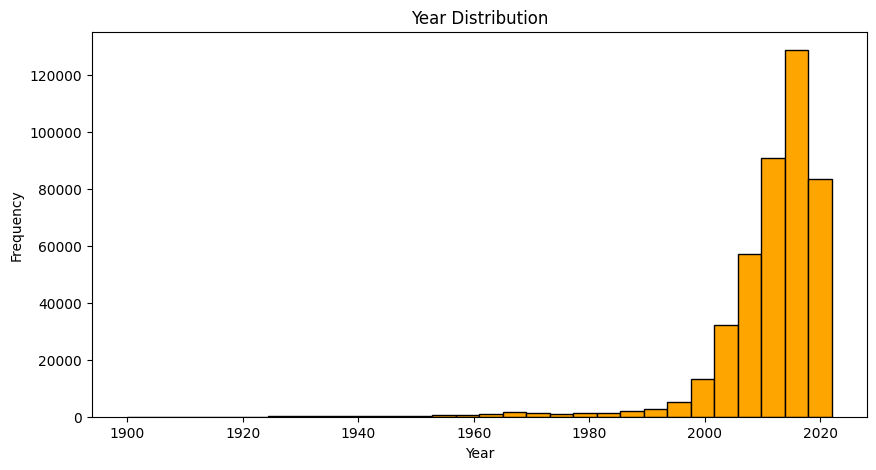

In [ ]:
# Year distribution
plt.figure(figsize=(10, 5))
plt.hist(df_cars['year'].dropna(), bins=30, edgecolor='black', color='orange')
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

> Most vehicles are from 2010-2020. Recent cars dominate the listings.

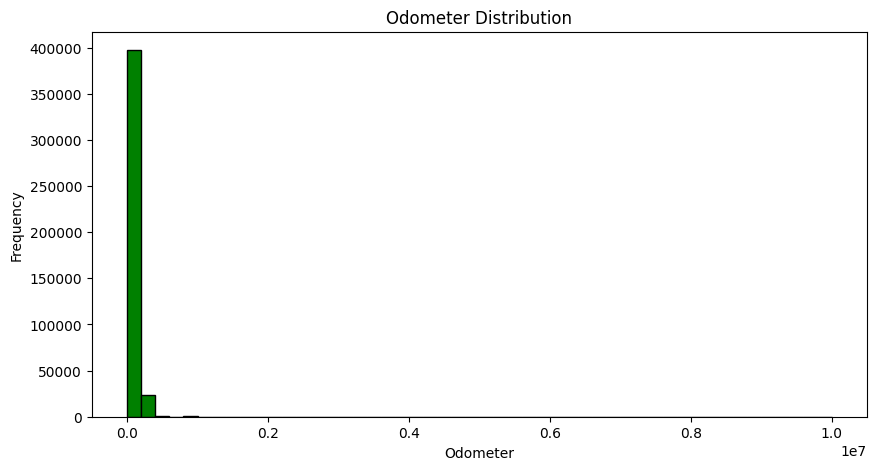

In [ ]:
# Odometer distribution
plt.figure(figsize=(10, 5))
plt.hist(df_cars['odometer'].dropna(), bins=50, edgecolor='black', color='green')
plt.title('Odometer Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.show()

> Mileage concentrated at 0-100k miles - mostly newer, lower-mileage vehicles.

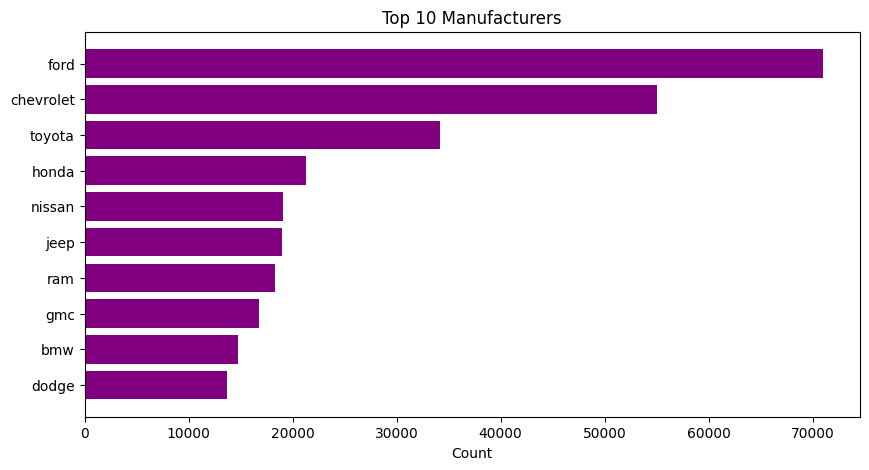

In [ ]:
# Top manufacturers
top_manufacturers = df_cars['manufacturer'].value_counts().head(10)
plt.figure(figsize=(10, 5))
plt.barh(top_manufacturers.index, top_manufacturers.values, color='purple')
plt.title('Top 10 Manufacturers')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.show()

>  Ford and Chevrolet lead significantly.

---

#  Data Cleaning


**Handling missing data :**
-

In [ ]:
# Select relevant columns, we do not select 'model' (too many unique values, too sparse and will hurt the model performance)
cols = ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'type']
df_clean = df_cars[cols].copy()

# Drop rows where target (price) or key features are missing - can't predict without them
print(f"Before: {df_clean.shape}")
df_clean = df_clean.dropna(subset=['price', 'year', 'odometer'])
print(f"After dropping missing price/year/odometer: {df_clean.shape}")

Before: (426880, 9)
After dropping missing price/year/odometer: (421344, 9)


In [ ]:
# Fill categorical columns with 'unknown' - missing likely means "not specified"
for col in ['manufacturer', 'condition', 'fuel', 'transmission', 'type']:
    df_clean[col] = df_clean[col].fillna('unknown')

# Fill cylinders with mode - discrete feature, mode is most representative
df_clean['cylinders'] = df_clean['cylinders'].fillna(df_clean['cylinders'].mode()[0])

print("Missing values remaining:", df_clean.isnull().sum().sum())

Missing values remaining: 0


---

#  Encode Categorical Variables



In [ ]:
# Encode categorical columns - converts text to integers
categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'type']
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

df_clean.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,14,2,6,2,57923.0,2,8
28,22590,2010.0,7,2,6,2,71229.0,2,8
29,39590,2020.0,7,2,6,2,19160.0,2,8
30,30990,2017.0,39,2,6,2,41124.0,2,8
31,15000,2013.0,13,0,5,2,128000.0,0,10


---

#  Feature Engineering



In [ ]:
# Car age: older cars typically worth less
df_clean['age'] = 2026 - df_clean['year']

# Mileage per year: high usage = more wear
df_clean['miles_per_year'] = df_clean['odometer'] / (df_clean['age'])


# Interaction: captures combined effect of age and annual mileage
df_clean['age_x_miles_per_year'] = df_clean['miles_per_year'] * df_clean['age']

# Quick preview of engineered features
df_clean[['year', 'age', 'odometer', 'miles_per_year', 'age_x_miles_per_year']].head()

,year,age,odometer,miles_per_year,age_x_miles_per_year
27,2014.0,12.0,57923.0,4826.916667,57923.0
28,2010.0,16.0,71229.0,4451.812500,71229.0
29,2020.0,6.0,19160.0,3193.333333,19160.0
30,2017.0,9.0,41124.0,4569.333333,41124.0
31,2013.0,13.0,128000.0,9846.153846,128000.0


---

#  Prepare Data for Modeling

In [ ]:
# Define features (X) and target (y)
feature_cols = ['year', 'odometer', 'age', 'miles_per_year',
                'manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'type',
             'age_x_miles_per_year']
X = df_clean[feature_cols]
y = df_clean['price']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (337075, 11), Test: (84269, 11)



**Scale Features**


In [ ]:
print(f"\nFeature ranges - Min: {X_train.min().min():.2f}, Max: {X_train.max().max():.2f}")
X_train.head(3)


Feature ranges - Min: 0.00, Max: 10000000.00


,year,odometer,age,miles_per_year,manufacturer,condition,cylinders,fuel,transmission,type,age_x_miles_per_year
334269,2006.0,63212.0,20.0,3160.600000,40,2,5,2,0,6,63212.0
360134,2010.0,77060.0,16.0,4816.250000,16,6,3,2,0,9,77060.0
385786,2014.0,92593.0,12.0,7716.083333,3,6,5,2,0,0,92593.0


In [ ]:
# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaled ranges - Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}")
pd.DataFrame(X_train_scaled, columns=X_train.columns).head(3)



Scaled ranges - Min: -11.75, Max: 179.22


,year,odometer,age,miles_per_year,manufacturer,condition,cylinders,fuel,transmission,type,age_x_miles_per_year
0,-0.552607,-0.163947,0.552607,-0.255925,1.664041,-0.482152,0.219741,-0.033512,-0.495248,-0.291098,-0.163947
1,-0.130137,-0.098912,0.130137,-0.136916,-0.299810,1.137933,-1.805001,-0.033512,-0.495248,0.436996,-0.098912
2,0.292333,-0.025964,-0.292333,0.071526,-1.363562,1.137933,0.219741,-0.033512,-0.495248,-1.747286,-0.025964


---

#  Train the Model

In [ ]:
# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print("Model trained!")

Model trained!


---

#  Evaluate the Model

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")

MAE:  $74,781.70
RMSE: $8,540,878.45


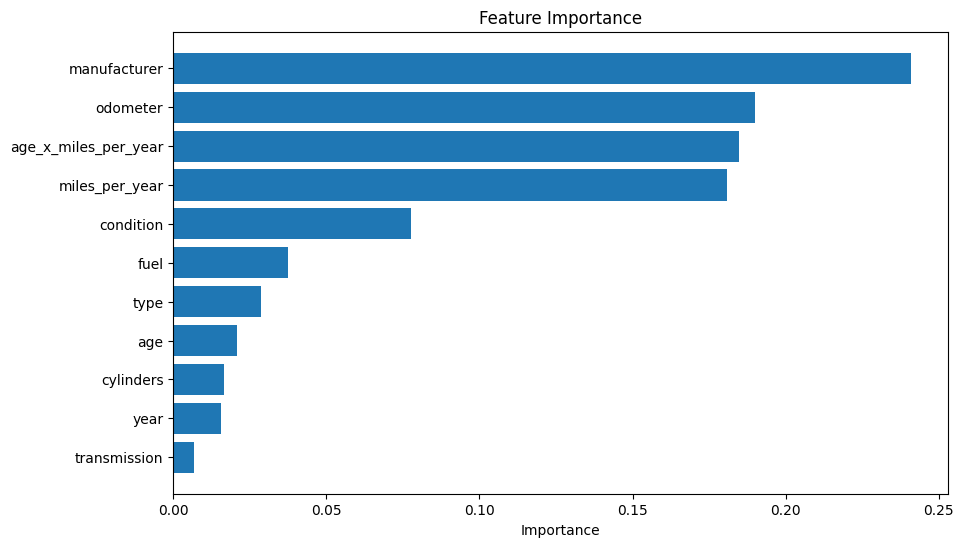

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

---

# 🔟 Cross-Validation with K-Fold

K-Fold splits the data into k equal folds for robust performance estimation.

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for train_idx, val_idx in kfold.split(X_train_scaled):
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train and predict
    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_val)

    # Calculate metrics
    mae_scores.append(mean_absolute_error(y_fold_val, y_fold_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))

mae_scores = np.array(mae_scores)
rmse_scores = np.array(rmse_scores)

print(f"5-Fold CV Results:")
print(f"MAE:  ${mae_scores.mean():,.2f}")
print(f"RMSE: ${rmse_scores.mean():,.2f}")

5-Fold CV Results:
MAE:  $135,958.57
RMSE: $13,326,430.36
